In [ ]:
import os, time, math, argparse, json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
CLASS_NAMES = ["cider","wheat","lager","ipa","stout","not_beer"]

In [ ]:
class BeerClassifier(nn.Module):
    def __init__(self, dropout=0.2, num_classes=6):
        super().__init__()
        def block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2)
            )

        self.features = nn.Sequential(
            block(3, 64),
            block(64, 128),
            block(128, 256),
            nn.Conv2d(256, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1))
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(dropout),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [ ]:
IMG_SIZE = 224

train_transform = transforms.Compose([
    transforms.Resize(int(IMG_SIZE * 1.1)),            # slightly larger
    transforms.RandomCrop(IMG_SIZE),                   # crop to final size
    transforms.RandomHorizontalFlip(p=0.5),            # bottles left/right
    transforms.RandomRotation(15),                     # small tilt
    transforms.ColorJitter(brightness=0.2,              # lighting variations
                           contrast=0.2,
                           saturation=0.15,
                           hue=0.05),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],   # ImageNet norms
                         std=[0.229, 0.224, 0.225]),
])

eval_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# For something like inference on a fixed size model
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])


In [ ]:
!rm -rf /content/sample_data/photos/.ipynb_checkpoints

dataset = datasets.ImageFolder(root="/content/sample_data/photos", transform=transform)

In [ ]:
train_ratio, val_ratio = 0.8, 0.1
train_size = int(train_ratio * len(dataset))
val_size   = int(val_ratio * len(dataset))
test_size  = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# --- Assign transforms ---
train_dataset.dataset.transform = train_transform  # train set gets aug
val_dataset.dataset.transform   = eval_transform   # val set = eval tfms
test_dataset.dataset.transform  = eval_transform   # test set = eval tfms

# --- DataLoaders ---
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False,num_workers=2)


In [ ]:
print(f"Train samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Train samples: 2744
Validation samples: 343
Test samples: 343


In [ ]:
def train_and_evaluate(lr, weight_decay, dropout, patience,
                       max_epochs=25, device="cuda" if torch.cuda.is_available() else "cpu"):
    model = BeerClassifier(dropout=dropout).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Step on validation accuracy (maximize)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=2, verbose=False
    )

    best_acc = 0.0
    best_state = None
    epochs_without_improve = 0

    print(f"\n=== Training with lr={lr:.6f}, wd={weight_decay:.6f}, dr={dropout:.3f}, patience={patience} ===")
    for epoch in range(1, max_epochs + 1):
        # ---- Train ----
        model.train()
        running_loss = 0.0
        total_train, correct_train = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad(set_to_none=True)
            logits = model(images)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            preds = logits.argmax(1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        train_loss = running_loss / total_train
        train_acc = correct_train / total_train

        # ---- Validate ----
        model.eval()
        correct_val, total_val = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                logits = model(images)
                preds = logits.argmax(1)
                total_val += labels.size(0)
                correct_val += (preds == labels).sum().item()

        val_acc = correct_val / total_val if total_val > 0 else 0.0

        # LR schedule on metric
        scheduler.step(val_acc)

        # Early stopping logic
        if val_acc > best_acc:
            best_acc = val_acc
            best_state = {k: v.detach().cpu() for k, v in model.state_dict().items()}
            epochs_without_improve = 0
            improved = "✅"
        else:
            epochs_without_improve += 1
            improved = "—"

        # Current LR
        current_lr = optimizer.param_groups[0]['lr']

        # Print progress
        print(f"Epoch [{epoch:02d}/{max_epochs}] | "
              f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
              f"Val Acc: {val_acc:.4f} | Best: {best_acc:.4f} {improved} | "
              f"LR: {current_lr:.6f}")

        if epochs_without_improve >= patience:
            print(f"⏹ Early stopping triggered at epoch {epoch}")
            break

    # Restore best weights
    if best_state is not None:
        model.load_state_dict({k: v.to(device) for k, v in best_state.items()})

    return best_acc


In [ ]:
lr_range = (0.001, 0.0001)
wd_range = (1e-6, 1e-3)
dropout_range = (0.1, 0.6)
patience_range = (2, 4)

num_trials = 10
best_score, best_params = 0.0, None
print(device)
for i in range(num_trials):
    params = {
        'lr': 10**np.random.uniform(np.log10(lr_range[0]), np.log10(lr_range[1])),
        'weight_decay': 10**np.random.uniform(np.log10(wd_range[0]), np.log10(wd_range[1])),
        'dropout': np.random.uniform(*dropout_range),
        'patience': np.random.randint(patience_range[0], patience_range[1] + 1),
    }
    acc = train_and_evaluate(**params, max_epochs=5)
    print(f"[{i+1}/{num_trials}] lr={params['lr']:.6f}, wd={params['weight_decay']:.6f}, "
          f"dr={params['dropout']:.3f}, pt={params['patience']} -> val acc={acc:.4f}")
    if acc > best_score:
        best_score, best_params = acc, params

print(f"\nBest config: lr={best_params['lr']:.6f}, wd={best_params['weight_decay']:.6f}, "
      f"dr={best_params['dropout']:.3f}, pt={best_params['patience']} -> val acc={best_score:.4f}")


cuda

=== Training with lr=0.000224, wd=0.000639, dr=0.170, patience=2 ===


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [01/5] | Train Loss: 1.3537 | Train Acc: 0.4869 | Val Acc: 0.5335 | Best: 0.5335 ✅ | LR: 0.000224
Epoch [02/5] | Train Loss: 1.2549 | Train Acc: 0.5343 | Val Acc: 0.5452 | Best: 0.5452 ✅ | LR: 0.000224
Epoch [03/5] | Train Loss: 1.1921 | Train Acc: 0.5576 | Val Acc: 0.5802 | Best: 0.5802 ✅ | LR: 0.000224
Epoch [04/5] | Train Loss: 1.1704 | Train Acc: 0.5827 | Val Acc: 0.5364 | Best: 0.5802 — | LR: 0.000224
Epoch [05/5] | Train Loss: 1.1459 | Train Acc: 0.5853 | Val Acc: 0.5802 | Best: 0.5802 — | LR: 0.000224
⏹ Early stopping triggered at epoch 5
[1/10] lr=0.000224, wd=0.000639, dr=0.170, pt=2 -> val acc=0.5802

=== Training with lr=0.000453, wd=0.000087, dr=0.386, patience=2 ===
Epoch [01/5] | Train Loss: 1.3843 | Train Acc: 0.4825 | Val Acc: 0.4694 | Best: 0.4694 ✅ | LR: 0.000453
Epoch [02/5] | Train Loss: 1.2793 | Train Acc: 0.5281 | Val Acc: 0.5277 | Best: 0.5277 ✅ | LR: 0.000453
Epoch [03/5] | Train Loss: 1.2352 | Train Acc: 0.5456 | Val Acc: 0.5656 | Best: 0.5656 ✅ | LR: 0.0

Epoch 1/50 | Train Loss: 1.3870 | Validation Accuracy: 47.23%
Epoch 2/50 | Train Loss: 1.2752 | Validation Accuracy: 56.27%
Epoch 3/50 | Train Loss: 1.2523 | Validation Accuracy: 53.06%
Epoch 4/50 | Train Loss: 1.1968 | Validation Accuracy: 51.02%
Epoch 5/50 | Train Loss: 1.1781 | Validation Accuracy: 55.69%
Epoch 6/50 | Train Loss: 1.1620 | Validation Accuracy: 60.35%
Epoch 7/50 | Train Loss: 1.1323 | Validation Accuracy: 58.60%
Epoch 8/50 | Train Loss: 1.1110 | Validation Accuracy: 57.43%
Epoch 9/50 | Train Loss: 1.0973 | Validation Accuracy: 59.48%
Epoch 10/50 | Train Loss: 1.0707 | Validation Accuracy: 60.35%
Epoch 11/50 | Train Loss: 1.0629 | Validation Accuracy: 55.69%
Epoch 12/50 | Train Loss: 1.0059 | Validation Accuracy: 65.31%
Epoch 13/50 | Train Loss: 0.9953 | Validation Accuracy: 63.85%
Epoch 14/50 | Train Loss: 0.9751 | Validation Accuracy: 62.68%
Epoch 15/50 | Train Loss: 0.9564 | Validation Accuracy: 63.56%
Epoch 16/50 | Train Loss: 0.9500 | Validation Accuracy: 64.14%
E

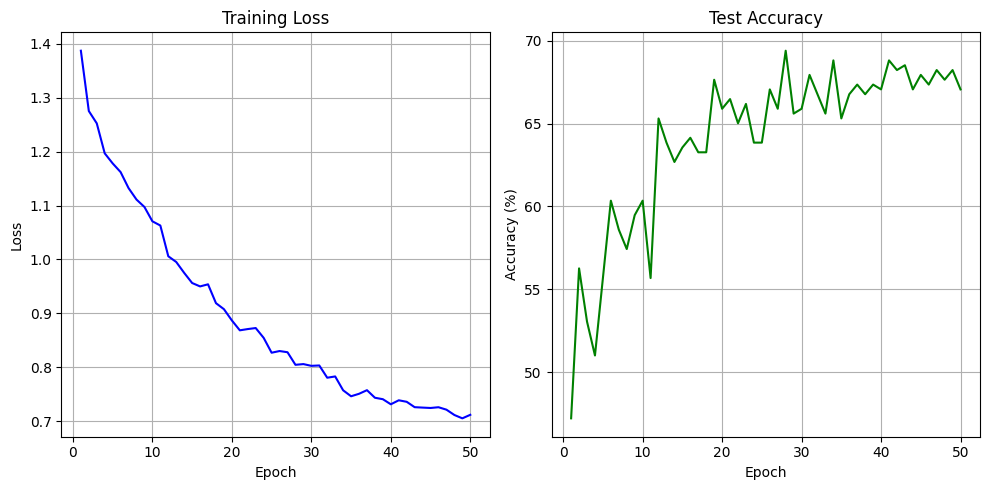

In [ ]:
best_lr, best_wd, best_dropout, best_patience = best_params['lr'], best_params['weight_decay'], best_params['dropout'], best_params['patience'] #From earlier because we dont want to run the validaion cell a lot of time

model = BeerClassifier(dropout=best_dropout).to(device)

# === Define optimizer, loss, scheduler ===
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=best_lr, weight_decay=best_wd)

    # Step on validation accuracy (maximize)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=best_patience, verbose=False
)

# === Train final model ===
final_epochs = 50
train_losses = []
test_accuracies = []

# === Best model tracking ===
best_acc = 0.0
best_model_state = None
best_epoch = -1

for epoch in range(final_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # === Evaluate on test set ===
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = correct / total
    test_accuracies.append(acc)

    scheduler.step(acc)

    # === Check if best ===
    if acc > best_acc:
        best_acc = acc
        best_model_state = model.state_dict()
        best_epoch = epoch + 1

    print(f"Epoch {epoch+1}/{final_epochs} | Train Loss: {train_loss:.4f} | Validation Accuracy: {acc*100:.2f}%")

# === Evaluate final model on the true test set ===
model.load_state_dict(best_model_state)  # Load best checkpoint
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_acc = correct / total
print(f"\n📊 Final Test Accuracy: {test_acc*100:.2f}%")

import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(10, 5))

# Plot train loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)

# Plot test accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, [acc * 100 for acc in test_accuracies], label='Test Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
torch.save(best_model_state, "model_weights50.pth")